In [1]:
import numpy as np
import pandas as pd
import os
import glob
import cv2

import torch
import torchvision
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt

from copy import deepcopy
from sklearn import cluster
from sklearn.model_selection import train_test_split
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, Dataset
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
root_dir = 'P1_Facial_Keypoints/data/training/'
all_image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [5]:
data.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


## Dataset

In [33]:
class FaceData(Dataset):
    def __init__(self, df):
        super(FaceData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = "P1_Facial_Keypoints/data/training/" + self.df.iloc[idx, 0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[idx, 1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()

        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2

    def preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)
        img = self.normalize(img).float()
        return img.to(device)

    def load_img(self, idx):
        img_path = "P1_Facial_Keypoints/data/training/" + self.df.iloc[idx, 0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224, 224))
        return img
    

In [34]:
train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FaceData(train.reset_index(drop=True))
test_dataset = FaceData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Define Model

In [35]:
def get_model():
    
    model = models.vgg16(pretrained=True)
    #ensure that the parameters of the pretrained model are frozen
    for param in model.parameters():
        param.requires_grad = False

    # overwrite and unfreeze the parameters of the two last layers of the model
    model.avgpool = nn.Sequential(
                                nn.Conv2d(512, 512, 3),
                                nn.MaxPool2d(2),
                                nn.Flatten() )
    model.classifier = nn.Sequential(
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(512, 136),
                                nn.Sigmoid() )
                        
    criterion = nn.L1Loss()  # loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer

## Training

In [36]:
model, criterion, optimizer = get_model()

In [37]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()    # zero gradients
    _kps_predict = model(img.to(device))   # predict
    loss = criterion(_kps_predict, kps.to(device))  # calculate loss
    loss.backward()  # backward
    optimizer.step() # update weights
    return loss

In [38]:
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps_predict = model(img.to(device))
    loss = criterion(_kps_predict, kps.to(device))
    return _kps_predict, loss

In [39]:
train_loss, test_loss = [], []
n_epochs = 10

for epoch in range(n_epochs):
    print(f" epoch {epoch+1}/{n_epochs}")
    epoch_train_loss, epoch_test_loss = 0., 0.
    for idx, (img, kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (idx+1)

    for idx, (img, kps) in enumerate(test_loader):
        preds, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (idx+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 epoch 1/10
 epoch 2/10
 epoch 3/10
 epoch 4/10
 epoch 5/10
 epoch 6/10
 epoch 7/10
 epoch 8/10
 epoch 9/10
 epoch 10/10


## Plot Losses

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [41]:
epochs = np.arange(n_epochs)+1

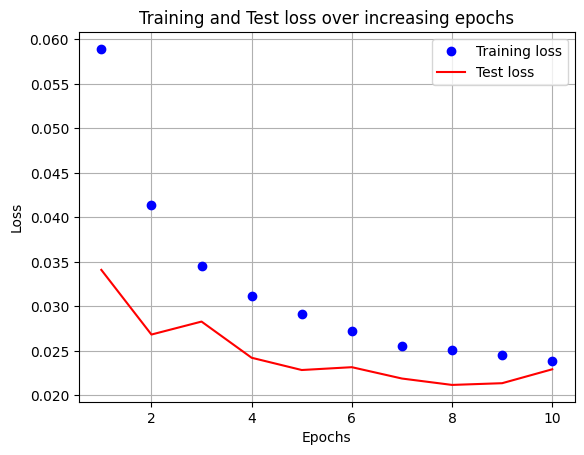

In [42]:
plt.plot(epochs, train_loss, "bo", label="Training loss")
plt.plot(epochs, test_loss, "r", label= "Test loss")
plt.title("Training and Test loss over increasing epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid("off")
plt.show()

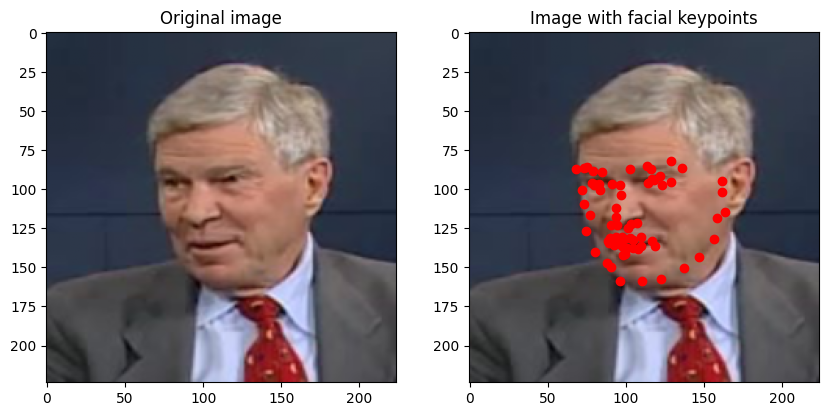

In [51]:
idx = 25
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.title("Original image")
image = test_dataset.load_img(idx)
plt.imshow(image)
plt.grid(False)
plt.subplot(222)
plt.title("Image with facial keypoints")
x, _ = test_dataset[idx]
plt.imshow(image)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c="r")
plt.grid(False)
plt.show()
